<a href="https://colab.research.google.com/github/chuducthang77/Deep-Learning-project/blob/main/course_work_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Build the network to train/predict the cifar100 dataset
- Evaluate the accuracy on the test set
- Save the model in the file (.h5) 
- Using tips: Pretrained model, augmentation, batchnorm, dropout, callbacks
- Model: Resnet, DenseNet, BiT, EfficientNet
- Visualization: Kernel, activation, saliency map, activation maximization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 3.7MB/s 


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [4]:
# parameters for data
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 10
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

In [5]:
(X, y), (X_test, y_test) = cifar100.load_data()

print("The shape of X_train : ", X.shape)
print("The shape of X_test : ", X_test.shape)

169009152/169001437 [==============================] - 3s 0us/step
The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)


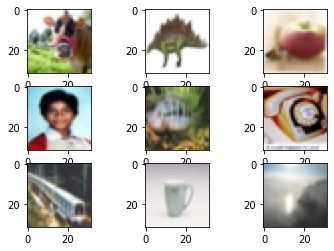

In [6]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X[i])
# show the figure
plt.show()

In [7]:
# Spliting the training data into a training data and a validation data.
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])


The number of training data :  40000
The number of validation data :  10000


In [8]:
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

In [9]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

In [10]:
train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)
test_generator = DataGenerator(X_test, y_test, augment = False)

In [11]:
import efficientnet.keras as efn 

efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
Total params: 4,182,784
Trainable params: 4,138,208
Non-trainable params: 44,576
_________________________________________________________________


In [12]:
optimizer = keras.optimizers.Adam(learning_rate=lr)

In [13]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['acc'])

In [14]:
#Link and save the model to Google Drive
!ln -s /content/drive/'My Drive'/'Machine Learning'

save_dir = 'Machine Learning'
model_name = 'model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)
callbacks = [checkpoint, es, rlrop]

In [15]:
hist = model.fit_generator(train_generator,validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
5000/5000 [==============================] - 770s 146ms/step - loss: 3.7864 - acc: 0.1856 - val_loss: 2.9342 - val_acc: 0.3994
Epoch 2/10
5000/5000 [==============================] - 708s 142ms/step - loss: 2.4289 - acc: 0.3832 - val_loss: 1.9410 - val_acc: 0.5123
Epoch 3/10
5000/5000 [==============================] - 700s 140ms/step - loss: 2.0561 - acc: 0.4542 - val_loss: 1.6778 - val_acc: 0.5749
Epoch 4/10
5000/5000 [==============================] - 719s 144ms/step - loss: 1.8180 - acc: 0.5100 - val_loss: 1.5554 - val_acc: 0.6072
Epoch 5/10
5000/5000 [==============================] - 709s 142ms/step - loss: 1.6584 - acc: 0.5465 - val_loss: 1.5815 - val_acc: 0.5979
Epoch 6/10
5000/5000 [==============================] - 691s 138ms/step - loss: 1.5530 - acc: 0.5696 - val_loss: 1.4494 - val_acc: 0.6321
Epoch 7/10
5000/5000 [==============================] - 688s 138ms/step - loss: 1.4725 - acc: 0.5933 - val_loss: 1.4375 - val_acc: 0.6429
Epoch 8/10
5000/5000 [============

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


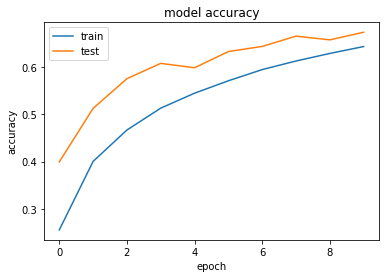

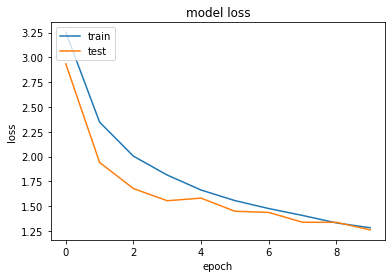

In [17]:
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(test_generator)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

In [ ]:
model.summary()